# Langevin equation numerical integration

(c) 2019 Manuel Razo. This work is licensed under a [Creative Commons
Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
All code contained herein is licensed under an [MIT
license](https://opensource.org/licenses/MIT)

In [77]:
# Import our numerical workhorse
import numpy as np

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

# Seaborn, useful for graphics
import seaborn as sns

# Import interactive plot module
import bokeh.io
import bokeh.plotting
import bokeh.layouts
from bokeh.themes import Theme
from bokeh.models import CustomJS, WidgetBox, ColumnDataSource
from bokeh.models.widgets import Slider, RadioButtonGroup
from bokeh.resources import CDN
from bokeh.embed import autoload_static

# Import the project utils
import sys
sys.path.insert(0, '../../')
import statgen

bokeh.io.output_notebook()

# Define output fig folder
figdir = '../../fig/drift_langevin/'

Loading BokehJS ...

In [2]:
# Set plotting style
statgen.viz.pboc_style_mpl()

# Increase dpi
mpl.rcParams['figure.dpi'] = 110


## Langevin equation
Our task for this script is to simulate a random walker in 1D that follows
the dynamics of the form
$$
{dx \over dt} = -\gamma x(t) + \xi(t),
$$
where $\gamma$ is the restoration force, and $\xi(t)$ is white noise with
properties
$$
\left\langle \xi(t) \right\rangle = 0,
$$
and
$$
\left\langle \xi(t) \xi(t') \right\rangle = 2D \delta(t-t'),
$$
where $D$ is the diffusion coefficient. We have shown already that the
average position of the random walker is given by
$$
\left\langle x(t) \right\rangle = x_o e^{-\gamma t}.
$$
We also showed that the variance of the position $\sigma^2(x(t))$ is given by
$$
\sigma^2(x(t)) = {D \over \gamma} \left( 1 - e^{-2 \gamma t} \right).
$$
So our task now is to simulate a random walker that follows this stochastic
differential equation and compare the statistics of the trajectories to our
analytical results.

### Numerical implementation of a Langevin equation
Let's now discuss how we are going to numerically simulate these stochastic
dynamics. The way we will work with this is by rewriting the Langevin equation as a discrete difference equation. This is
$$
{x(t + \Delta t) - x(t) \over \Delta t} = -\gamma x(t) + \xi(t).
$$
If we solve for $x(t + \Delta t)$ we find
$$
x(t + \Delta t) = x(t) -\gamma x(t) \Delta t + \xi(t) \Delta t.
$$
With this discrete version of the equation we can simply use Euler's integration method to integrate the equation. What this implies is that given a value for the parameters $\gamma$ and $D$, an initial condition $x_o$ and a time step $\Delta t$ sufficiently small all we have to do is follow the recipe given by this discrete Langevin equation. To include the random step $\xi(t)$ all we have to do is generate a Gaussian pseudo-random number. Let's code a function to perform this numerical integration.





In [33]:
def euler_langevin(xo, gamma, D, delta_t, n_steps=500):
    '''
    Numerical integration of the Langevin equation of the form
    dx/dt = -gamma x + xi.
    Parameters
    ----------
    xo : array-like.
        Initial position of walker(s). The number of simulations performed
        is equivalent to the number of initial conditions listed in xo.
    gamma : float.
        Restoration "force" parameter.
    D : float.
        Diffusion coefficient.
    delta_t : float.
        Time step size.
    n_steps : int. Default=500.
        Number of steps to use for the integration
    '''
    # Initialize matrix to save all trajectories
    x_mat = np.zeros([len(xo), n_steps + 1])
    
    # Set initial condition
    x_mat[:, 0] = xo
    
    # Generate all necessary random numbers
    xi_mat = np.random.normal(0, np.sqrt(2 * D * delta_t), [len(xo), n_steps])
    
    # Loop through time steps
    for n in range(n_steps):
        # Update position according to discrete Langevin equation
        x_mat[:, n + 1] = x_mat[:, n] - gamma * x_mat[:, n] * delta_t +\
                          xi_mat[:, n]
        
    return x_mat

Let's test the function now.

In [95]:
# Define random seed for reproducible results
np.random.seed(42)

# Define initial position
xo = np.ones(100) * 2

# Define parameters
gamma = 1
D = 1
delta_t = 0.001
n_steps = 6000

# Define time array
time = np.arange(n_steps + 1) * delta_t

# Run function
x_mat = euler_langevin(xo, gamma, D, delta_t, n_steps)

Having generated random trajectories, let's also compute the mean and analytical variance that we expect for these dynamics along with the ones we obtained from the simulations.

In [96]:
# Compute mean trajectory as a function of time
langevin_mean = xo[0] * np.exp(- gamma * time)

# Compute variance in trajectory
langevin_var = D / gamma * (1 - np.exp(-2 * gamma * time))

# Compute trajectories mean
exp_mean = np.mean(x_mat, axis=0)

# Compute trajectories standard deviation
exp_std = np.std(x_mat, axis=0)

### Matplotlib plot of numerical integration

Let's now look at the trajectories along with a sense for mean $\pm$ standard deviation.

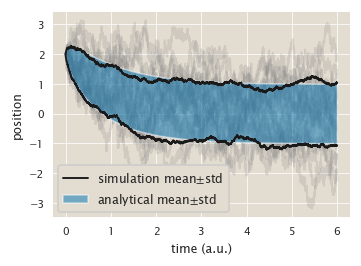

In [98]:
# Plot trajectories
plt.plot(time, x_mat[0::5, :].T, color='gray', alpha=0.2, label='')

plt.fill_between(time, langevin_mean + np.sqrt(langevin_var),
                 langevin_mean - np.sqrt(langevin_var), zorder=10,
                 alpha=0.5, label=r'analytical mean$\pm$std')

# Plot simulations mean
# plt.plot(time, exp_mean, color='k', zorder=10)

# Plot simulations mean +- std
plt.plot(time, exp_mean + exp_std, color='k', zorder=10,
         label=r'simulation mean$\pm$std')
plt.plot(time, exp_mean - exp_std, color='k', zorder=10)

# Label axis
plt.xlabel('time (a.u.)')
plt.ylabel('position')

# Set ylimit
# Add legend
plt.legend()

# Save figure
plt.savefig(figdir + '02_01_langevin_euler.png', bbox_inches='tight',
            dpi=300)